In [1]:
import os
import torch

import scanpy as sc
import numpy as np
import pandas as pd
import gseapy as gp

from tqdm import tqdm
from sklearn.cluster import KMeans
from contrastive_vi.model.contrastive_vi import ContrastiveVIModel
from scripts import constants
from scvi._settings import settings

Global seed set to 0


In [2]:
settings.seed = 0
device = "cuda:1"
dataset = "mcfarland_2020"

Global seed set to 0


In [3]:
pathway_enr_fdr = 0.05

In [4]:
split_key = constants.DATASET_SPLIT_LOOKUP[dataset]["split_key"]
background_value = constants.DATASET_SPLIT_LOOKUP[dataset]["background_value"]
label_key = constants.DATASET_SPLIT_LOOKUP[dataset]["label_key"]
seeds = constants.DEFAULT_SEEDS
latent_size = 10

In [5]:
adata = sc.read_h5ad(
    os.path.join(
        constants.DEFAULT_DATA_PATH,
        f"{dataset}/preprocessed/adata_top_2000_genes_tc.h5ad",
    )
)
ContrastiveVIModel.setup_anndata(adata, layer="count")

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["count"]                                               
INFO     Successfully registered anndata object containing 5928 cells, 2000 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


/homes/gws/ewein/miniconda3/envs/contrastiveVI/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [6]:
target_indices = np.where(adata.obs[split_key] != background_value)[0]
target_adata = adata[target_indices]
background_indices = np.where(adata.obs[split_key] == background_value)[0]
background_adata = adata[background_indices]

In [7]:
contrastiveVI_model_list = []
contrastiveVI_latent_rep_list = []
scVI_model_list = []
for seed in tqdm(seeds):
    contrastiveVI_result_dir = os.path.join(
        constants.DEFAULT_RESULTS_PATH,
        f"{dataset}/contrastiveVI/latent_{latent_size}",
        f"{seed}",
    )
    contrastiveVI_model_list.append(
        torch.load(
            os.path.join(contrastiveVI_result_dir, "model.ckpt"),
            map_location=device,
        ),
    )
    
    contrastiveVI_latent_rep_list.append(
        np.load(os.path.join(contrastiveVI_result_dir, "latent_representations.npy")),
    )

    scvi_result_dir = os.path.join(
        constants.DEFAULT_RESULTS_PATH,
        f"{dataset}/scVI_with_background/latent_{latent_size}",
        f"{seed}",
    )

    scVI_model_list.append(
        torch.load(
            os.path.join(scvi_result_dir, "model.ckpt"),
            map_location=device,
        ),
    )

100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.65s/it]


In [8]:
from scipy.stats import spearmanr
from collections import defaultdict

correlations_total = defaultdict(list)

for (scVI_model, contrastiveVI_model, latent_rep) in zip(
    scVI_model_list, contrastiveVI_model_list, contrastiveVI_latent_rep_list
):
    cluster_label_key = f"cluster_{seed}"

    contrastive_vi_latent_clusters = (
        KMeans(n_clusters=2, random_state=123)
        .fit(latent_rep)
        .labels_
    )

    tmp_target_adata = target_adata.copy()
    tmp_target_adata.obs[cluster_label_key] = [str(x) for x in contrastive_vi_latent_clusters]
    
    wild_type_proportions = {}

    # Infer which cluster approximately corresponds to the TP53 mutation cells vs wild type cells
    for cluster_idx in ["0", "1"]:
        wild_type_proportions[cluster_idx] = (
            tmp_target_adata[
                (tmp_target_adata.obs[cluster_label_key] == cluster_idx) & (tmp_target_adata.obs['TP53_mutation_status'] == 'Wild Type')
            ].shape[0] / tmp_target_adata[tmp_target_adata.obs[cluster_label_key] == cluster_idx].shape[0]
        )

    wild_type_cluster = "0" if wild_type_proportions["0"] > wild_type_proportions["1"] else "1"
    assigned_label_key = "assigned_label"
    assigned_labels = ["Wild Type" if x == wild_type_cluster else "Mutation" for x in tmp_target_adata.obs[cluster_label_key]]
    tmp_target_adata.obs[assigned_label_key] = assigned_labels
    
    tmp_background_adata = background_adata.copy()
    tmp_background_adata.obs[assigned_label_key] = "background"
    
    for label in ["Mutation", "Wild Type"]:
        
        cluster_adata = tmp_background_adata.concatenate(
            tmp_target_adata[tmp_target_adata.obs[assigned_label_key] == label]
        )

        scVI_de_result = scVI_model.differential_expression(
            adata=cluster_adata,
            groupby=assigned_label_key,
            group1="background",
            group2=label,
            idx1=None,
            idx2=None,
            mode="change",
            delta=0.25,
            batch_size=128,
            all_stats=True,
            batch_correction=False,
            batchid1=None,
            batchid2=None,
            fdr_target=0.05,
            silent=False,
            n_samples=100,
        )

        contrastiveVI_de_result = contrastiveVI_model.differential_expression(
            adata=cluster_adata,
            groupby=assigned_label_key,
            group1="background",
            group2=label,
            idx1=None,
            idx2=None,
            mode="change",
            delta=0.25,
            batch_size=128,
            all_stats=True,
            batch_correction=False,
            batchid1=None,
            batchid2=None,
            fdr_target=0.05,
            silent=False,
            target_idx=np.where(cluster_adata.obs[split_key] != background_value)[0]
        )

        correlations_total[label].append(spearmanr(
            scVI_de_result['bayes_factor'].values,
            contrastiveVI_de_result['bayes_factor'].values
        )[0])

INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.layers["count"]                                               
INFO     Registered keys:['X', 'batch_indices', 'labels']                                    
INFO     Successfully registered anndata object containing 4776 cells, 2000 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/homes/gws/ewein/miniconda3/envs/contrastiveVI/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/homes/gws/ewein/miniconda3/envs/contrastiveVI/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function transfer_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.
  warnings.warn(msg, category=FutureWarning)


DE...: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.layers["count"]                                               
INFO     Registered keys:['X', 'batch_indices', 'labels']                                    
INFO     Successfully registered anndata object containing 3983 cells, 2000 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/homes/gws/ewein/miniconda3/envs/contrastiveVI/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/homes/gws/ewein/miniconda3/envs/contrastiveVI/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function transfer_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.
  warnings.warn(msg, category=FutureWarning)


DE...: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.layers["count"]                                               
INFO     Registered keys:['X', 'batch_indices', 'labels']                                    
INFO     Successfully registered anndata object containing 5194 cells, 2000 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/homes/gws/ewein/miniconda3/envs/contrastiveVI/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/homes/gws/ewein/miniconda3/envs/contrastiveVI/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function transfer_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.
  warnings.warn(msg, category=FutureWarning)


DE...: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.layers["count"]                                               
INFO     Registered keys:['X', 'batch_indices', 'labels']                                    
INFO     Successfully registered anndata object containing 3565 cells, 2000 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/homes/gws/ewein/miniconda3/envs/contrastiveVI/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/homes/gws/ewein/miniconda3/envs/contrastiveVI/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function transfer_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.
  warnings.warn(msg, category=FutureWarning)


DE...: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.layers["count"]                                               
INFO     Registered keys:['X', 'batch_indices', 'labels']                                    
INFO     Successfully registered anndata object containing 5296 cells, 2000 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/homes/gws/ewein/miniconda3/envs/contrastiveVI/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/homes/gws/ewein/miniconda3/envs/contrastiveVI/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function transfer_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.
  warnings.warn(msg, category=FutureWarning)


DE...: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.layers["count"]                                               
INFO     Registered keys:['X', 'batch_indices', 'labels']                                    
INFO     Successfully registered anndata object containing 3463 cells, 2000 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/homes/gws/ewein/miniconda3/envs/contrastiveVI/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/homes/gws/ewein/miniconda3/envs/contrastiveVI/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function transfer_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.
  warnings.warn(msg, category=FutureWarning)


DE...: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.layers["count"]                                               
INFO     Registered keys:['X', 'batch_indices', 'labels']                                    
INFO     Successfully registered anndata object containing 5253 cells, 2000 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/homes/gws/ewein/miniconda3/envs/contrastiveVI/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/homes/gws/ewein/miniconda3/envs/contrastiveVI/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function transfer_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.
  warnings.warn(msg, category=FutureWarning)


DE...: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.layers["count"]                                               
INFO     Registered keys:['X', 'batch_indices', 'labels']                                    
INFO     Successfully registered anndata object containing 3506 cells, 2000 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/homes/gws/ewein/miniconda3/envs/contrastiveVI/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/homes/gws/ewein/miniconda3/envs/contrastiveVI/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function transfer_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.
  warnings.warn(msg, category=FutureWarning)


DE...: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.layers["count"]                                               
INFO     Registered keys:['X', 'batch_indices', 'labels']                                    
INFO     Successfully registered anndata object containing 4338 cells, 2000 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/homes/gws/ewein/miniconda3/envs/contrastiveVI/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/homes/gws/ewein/miniconda3/envs/contrastiveVI/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function transfer_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.
  warnings.warn(msg, category=FutureWarning)


DE...: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.layers["count"]                                               
INFO     Registered keys:['X', 'batch_indices', 'labels']                                    
INFO     Successfully registered anndata object containing 4421 cells, 2000 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/homes/gws/ewein/miniconda3/envs/contrastiveVI/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/homes/gws/ewein/miniconda3/envs/contrastiveVI/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function transfer_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.
  warnings.warn(msg, category=FutureWarning)


DE...: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]


In [9]:
import matplotlib.pyplot as plt
from scipy.stats import sem

Text(0.5, 1.0, 'Evaluating contrastiveVI target vs. background DE test')

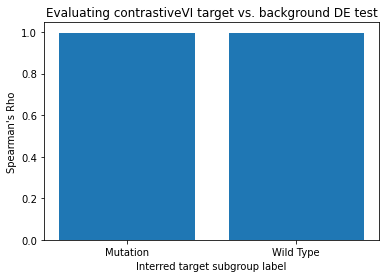

In [10]:
fig, ax = plt.subplots(1, 1)

labels = ["Mutation", "Wild Type"]
ax.bar(
    labels,
    [np.mean(correlations_total[label]) for label in labels],
    yerr=[sem(correlations_total[label]) for label in labels]
)

ax.set_ylabel("Spearman's Rho")
ax.set_xlabel("Interred target subgroup label")
ax.set_title("Evaluating contrastiveVI target vs. background DE test")